In [1]:
import os
import emcee
import corner
import random
import numpy as np
import scipy as sp
from astropy.io import fits
from scipy.stats import chi2
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from PyAstronomy.pyasl import rotBroad
from PyAstronomy.pyasl import fastRotBroad
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
# NP Necessary imports

In [3]:
cdir = '/d/hya1/BS/model_spectra/conv/'
# NP Convolved model directory
cnames = np.array(os.listdir(cdir))
# NP Convolved model names
cifiles = [n[-4:] == '.txt' for n in cnames]
# NP Finding indices of files ending in .txt
cmodel = [np.loadtxt(cdir +i, usecols = (0, 1)) for i in cnames[cifiles]]
# NP Reading in model data
ctemps = np.array([float(n[-12:-7]) for n in cnames[cifiles]])
# NP Finding temperature information for each model
cgs = np.array([float(n[-7:-4]) /100 for n in cnames[cifiles]])
# NP Finding gravity information for each model
vsini = np.array([float(n[4:-12]) for n in cnames[cifiles]])
# NP Reading vsini information from names
cwavlsvac = [i.T[0] for i in cmodel]
# NP Reading in vaccuum wavelengths
cints = [i.T[1] for i in cmodel]
# NP Reading in normalized fluxes
s = [1e4 /w for w in cwavlsvac]
nstp = [1 +0.0000834254 +0.02406147 /(130 -es**2) +0.00015998 /(38.9 -es**2) for es in s]
cwavls = [cwavlsvac[i] /nstp[i] for i in range(len(nstp))]

In [11]:
# NP Converting to air wavelengths adjusting for different indices of
# NP refraction in air of different wavelengths following this guide:
# NP https://emtoolbox.nist.gov/Wavelength/Documentation.asp#EdlenorCiddor
s = [1e4 /w for w in cwavlsvac]
P = 73251
# NP Pressure at APO in Pascals
T = 20
# NP Approximate temperature at APO in Celsius
A = 8342.54
B = 2406147
C = 15998
D = 96095.43
E = 0.601
F = 0.00972
G = 0.003661
# NP Constants for conversions
nstp = [1 +1e-8 *(A +B /(130 -es **2) +C /(38.9 -es **2)) for es in s]
# NP Index of refraction of air at STP for different wavelengths
X = (1 +1e-8 *(E -F *T) *P) /(1 +G *T)
n_tp = [1 +P *(n -1) *X /D for n in nstp]
# NP Index of refraction of air at the temperature and pressure of APO
cwavls = [cwavlsvac[i] /n_tp[i] for i in range(len(n_tp))]
# NP Converting to air wavelengths

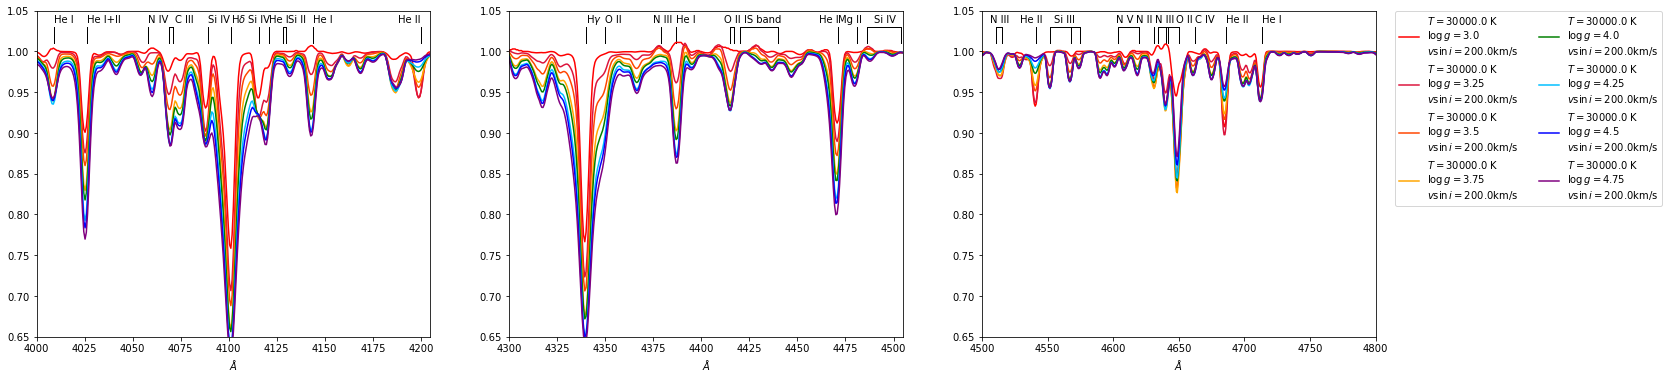

In [69]:
colors = ['red', 'crimson', 'orangered', 'orange', 'green', 'deepskyblue', 'blue', 'purple', 'black']
ci = 0
plt.figure(facecolor = 'white', figsize = [24, 6])

plt.subplot(1, 3, 1)       
plt.axvline(x=4009, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4009, 1.035, r'He I')
plt.axvline(x=4026, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4026, 1.035, r'He I+II')
plt.axvline(x=4058, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4058, 1.035, r'N IV')
plt.axvline(x=4069, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4071, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4069, xmax = 4071, color = 'k', linewidth = 1)
plt.text(4072, 1.035, r'C III')
plt.axvline(x=4089, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4089, 1.035, r'Si IV')
plt.axvline(x=4101, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4101, 1.035, r'H$\delta$')
plt.axvline(x=4116, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4116-6, 1.035, r'Si IV')
plt.axvline(x=4121, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4121, 1.035, r'He I')
plt.axvline(x=4128, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4130, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4128, xmax = 4130, color = 'k', linewidth = 1)
plt.text(4129+2, 1.035, r'Si II')
plt.axvline(x=4144, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4144, 1.035, r'He I')
plt.axvline(x=4200, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4188, 1.035, r'He II')
plt.xlabel(r'$\AA$')

plt.subplot(1, 3, 2)
plt.axvline(x=4340, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4340, 1.035, r'H$\gamma$')
plt.axvline(x=4350, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4350, 1.035, r'O II')
plt.axvline(x=4379, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4375, 1.035, r'N III')
plt.axvline(x=4387, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4387, 1.035, r'He I')
plt.axvline(x=4415, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4417, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4415, xmax = 4417, color = 'k', linewidth = 1)
plt.text(4412, 1.035, r'O II')
plt.axvline(x=4420, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4440, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4420, xmax = 4440, color = 'k', linewidth = 1)
plt.text(4422, 1.035, r'IS band')
plt.axvline(x=4471, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4471-10, 1.035, r'He I')
plt.axvline(x=4481, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4481-10, 1.035, r'Mg II')
plt.axvline(x=4486, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4504, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4486, xmax = 4504, color = 'k', linewidth = 1)
plt.text(4490, 1.035, r'Si IV')
plt.xlabel(r'$\AA$')

plt.subplot(1, 3, 3)
plt.axvline(x=4511, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4515, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4511, xmax = 4515, color = 'k', linewidth = 1)
plt.text(4506, 1.035, r'N III')
plt.axvline(x=4541, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4541-12, 1.035, r'He II')
plt.axvline(x=4552, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4568, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4575, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4552, xmax = 4575, color = 'k', linewidth = 1)
plt.text(4555, 1.035, r'Si III')
plt.axvline(x=4604, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4620, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4604, xmax = 4620, color = 'k', linewidth = 1)
plt.text(4602, 1.035, r'N V')
plt.axvline(x=4634, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4640, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4642, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4634, xmax = 4642, color = 'k', linewidth = 1)
plt.text(4632, 1.035, r'N III')
plt.axvline(x=4640, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.axvline(x=4650, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.hlines(y = 1.03, xmin = 4640, xmax = 4650, color = 'k', linewidth = 1)
plt.text(4648, 1.035, r'O II')
plt.axvline(x=4631, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4631-14, 1.035, r'N II')
plt.axvline(x=4662, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4662, 1.035, r'C IV')
plt.axvline(x=4686, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4686, 1.035, r'He II')
plt.axvline(x=4713, color= 'k', linewidth = 1, ymax = 0.95, ymin = 0.90)
plt.text(4713, 1.035, r'He I')
plt.xlabel(r'$\AA$')

for i in range(len(cnames)):
    if ctemps[i] == 30000 and cgs[i] > 0 and vsini[i] == 200:
        plt.subplot(1, 3, 1)
        plt.plot(cwavls[i], cints[i], color = colors[ci % len(colors)], \
                 label = r'$T=$' +str(ctemps[i]) +' K\n' +r'$\log g=$' \
                 +str(cgs[i]) +'\n' +r'$v\sin i=$' +str(vsini[i]) +'km/s')

        plt.xlim(4000, 4205)
        plt.ylim(0.65, 1.05)
        
        plt.subplot(1, 3, 2)
        plt.plot(cwavls[i], cints[i], color = colors[ci % len(colors)], \
                 label = r'$T=$' +str(ctemps[i]) +' K\n' +r'$\log g=$' \
                 +str(cgs[i]) +'\n' +r'$v\sin i=$' +str(vsini[i]) +'km/s')
        plt.xlim(4300, 4505)
        plt.ylim(0.65, 1.05)
        
        plt.subplot(1, 3, 3)
        plt.plot(cwavls[i], cints[i], color = colors[ci % len(colors)], \
                 label = r'$T=$' +str(ctemps[i]) +' K\n' +r'$\log g=$' \
                 +str(cgs[i]) +'\n' +r'$v\sin i=$' +str(vsini[i]) +'km/s')
        ci += 1
        plt.xlim(4500, 4800)
        plt.ylim(0.65, 1.05)
        
plt.legend(bbox_to_anchor=(1.05, 1),
            loc='upper left', ncol = 2, borderaxespad=0.)